# Assignment 5 — Build and Evaluate Classification Models (ISLR Ch. 4)

This notebook contains:

1. **Conceptual Question #1 (ISLR Ch. 4, p.193)** — Algebraic proof that the logistic form and logit form are equivalent.
2. **Applied Question #13 (ISLR Weekly data, pp.196–197)** — Parts (a)–(j) using `Weekly.csv`.
3. **Kaggle (Obesity Risk, Multi-class)** — Four required models and creation of `submission.csv`.

**Expected local files**
- `Weekly.csv`
- `train.csv` and `test.csv` (Kaggle dataset)


In [54]:
# Core
import numpy as np
import pandas as pd

# Plots
import matplotlib.pyplot as plt

# Metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score

# Modeling
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV

# Statsmodels for ISLR-style logistic regression summaries
import statsmodels.api as sm

pd.set_option("display.width", 120)
pd.set_option("display.max_columns", 50)


## 1) Conceptual Question #1 — Prove (4.2) is equivalent to (4.3)

Let \(p(X)=P(Y=1\mid X)\). The logistic function form is:

\[
p(X)=\frac{e^{\beta_0+\beta_1X}}{1+e^{\beta_0+\beta_1X}}.
\]

### Show logistic form \(\Rightarrow\) logit form

Let \(\eta=\beta_0+\beta_1X\). Then:

\[
1-p(X)=1-\frac{e^\eta}{1+e^\eta}=\frac{1}{1+e^\eta}.
\]

Compute the odds:

\[
\frac{p(X)}{1-p(X)}=\frac{\frac{e^\eta}{1+e^\eta}}{\frac{1}{1+e^\eta}}=e^\eta.
\]

Take logs:

\[
\log\left(\frac{p(X)}{1-p(X)}\right)=\log(e^\eta)=\eta=\beta_0+\beta_1X.
\]

That is the logit representation.

### Show logit form \(\Rightarrow\) logistic form

Start with:

\[
\log\left(\frac{p(X)}{1-p(X)}\right)=\beta_0+\beta_1X.
\]

Exponentiate:

\[
\frac{p(X)}{1-p(X)}=e^{\beta_0+\beta_1X}.
\]

Solve for \(p(X)\):

\[
p(X)=(1-p(X))e^{\beta_0+\beta_1X}
\Rightarrow p(X)(1+e^{\beta_0+\beta_1X})=e^{\beta_0+\beta_1X}
\Rightarrow p(X)=\frac{e^{\beta_0+\beta_1X}}{1+e^{\beta_0+\beta_1X}}.
\]

Therefore, (4.2) and (4.3) are equivalent.


In [55]:
## 2) Applied Question #13 — Weekly dataset

# Load Weekly
weekly = pd.read_csv("Weekly.csv")

weekly.head()


,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


In [56]:
# (a) Numerical and graphical summaries; patterns

weekly.info()
weekly.describe(include="all")

# Class balance
weekly["Direction"].value_counts(), weekly["Direction"].value_counts(normalize=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1089 entries, 0 to 1088
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Year       1089 non-null   int64  
 1   Lag1       1089 non-null   float64
 2   Lag2       1089 non-null   float64
 3   Lag3       1089 non-null   float64
 4   Lag4       1089 non-null   float64
 5   Lag5       1089 non-null   float64
 6   Volume     1089 non-null   float64
 7   Today      1089 non-null   float64
 8   Direction  1089 non-null   object 
dtypes: float64(7), int64(1), object(1)
memory usage: 76.7+ KB


(Direction
 Up      605
 Down    484
 Name: count, dtype: int64,
 Direction
 Up      0.555556
 Down    0.444444
 Name: proportion, dtype: float64)

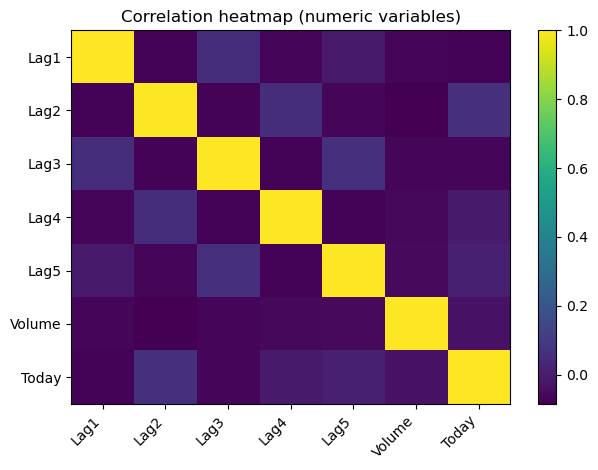

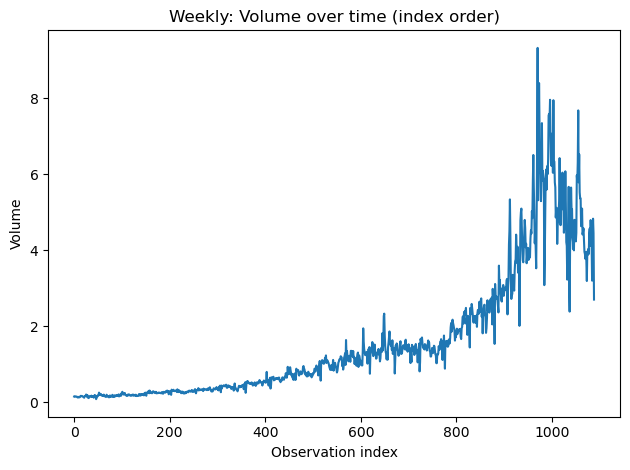

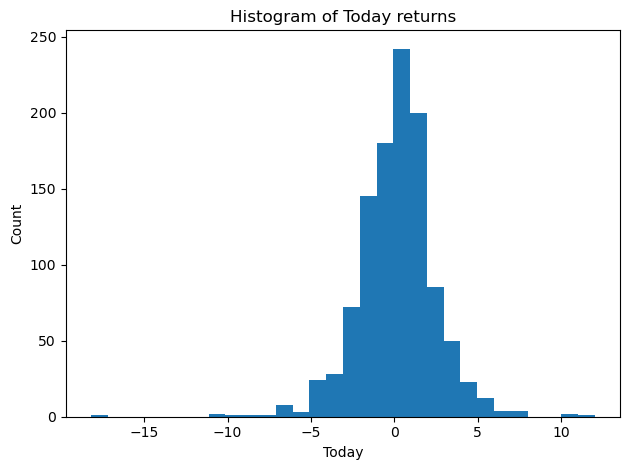

<Figure size 640x480 with 0 Axes>

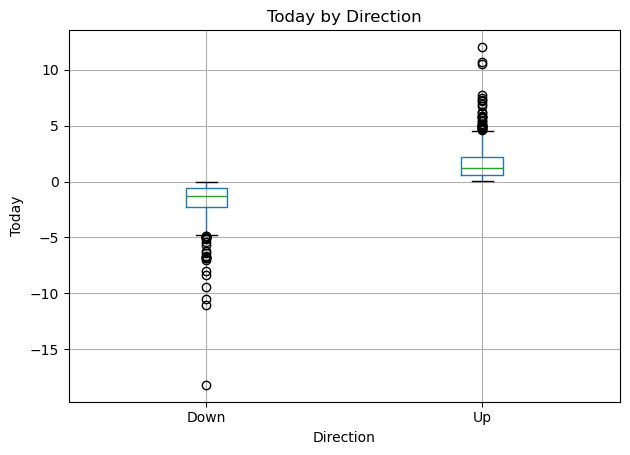

In [57]:
# Correlation among numeric predictors + plots

num_cols = ["Lag1","Lag2","Lag3","Lag4","Lag5","Volume","Today"]
corr = weekly[num_cols].corr()
corr.round(3)

plt.figure()
plt.imshow(corr.values, aspect="auto")
plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha="right")
plt.yticks(range(len(num_cols)), num_cols)
plt.title("Correlation heatmap (numeric variables)")
plt.colorbar()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(weekly["Volume"].values)
plt.title("Weekly: Volume over time (index order)")
plt.xlabel("Observation index")
plt.ylabel("Volume")
plt.tight_layout()
plt.show()

plt.figure()
plt.hist(weekly["Today"].values, bins=30)
plt.title("Histogram of Today returns")
plt.xlabel("Today")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure()
weekly.boxplot(column="Today", by="Direction")
plt.title("Today by Direction")
plt.suptitle("")
plt.xlabel("Direction")
plt.ylabel("Today")
plt.tight_layout()
plt.show()


In [58]:
# Prepare response variable: Up=1, Down=0
weekly = weekly.copy()
weekly["Direction01"] = (weekly["Direction"] == "Up").astype(int)

# (b) Logistic regression: Direction ~ Lag1+...+Lag5+Volume
X_full = weekly[["Lag1","Lag2","Lag3","Lag4","Lag5","Volume"]]
X_full_sm = sm.add_constant(X_full)
y_full = weekly["Direction01"]

logit_full = sm.Logit(y_full, X_full_sm).fit(disp=False)
logit_full.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            Direction01   No. Observations:                 1089
Model:                          Logit   Df Residuals:                     1082
Method:                           MLE   Df Model:                            6
Date:                Thu, 18 Dec 2025   Pseudo R-squ.:                0.006580
Time:                        10:37:47   Log-Likelihood:                -743.18
converged:                       True   LL-Null:                       -748.10
Covariance Type:            nonrobust   LLR p-value:                    0.1313
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2669      0.086      3.106      0.002       0.098       0.435
Lag1          -0.0413      0.026     -1.563      0.118      -0.093       0.010
Lag2           0.0584      0.027      2.175      0.030       0.006       0.111
Lag3          -0.0161      0.027     -0.602      0.547      -0.068       0.036
Lag4          -0.0278      0.026     -1.050      0.294      -0.080       0.024
Lag5          -0.0145      0.026     -0.549      0.583      -0.066       0.037
Volume        -0.0227      0.037     -0.616      0.538      -0.095       0.050
==============================================================================
"""

In [59]:
# (c) Confusion matrix and accuracy for full-data logistic regression

proba_full = logit_full.predict(X_full_sm)
pred_full = (proba_full >= 0.5).astype(int)

cm_full = confusion_matrix(y_full, pred_full)
acc_full = accuracy_score(y_full, pred_full)

cm_full, acc_full


(array([[ 54, 430],
        [ 48, 557]]),
 0.5610651974288338)

In [60]:
# Train/test split: train = 1990–2008, test = 2009–2010 (held out)

train = weekly[weekly["Year"] <= 2008].copy()
test = weekly[weekly["Year"] >= 2009].copy()

X_train = train[["Lag2"]]
X_test = test[["Lag2"]]
y_train = (train["Direction"] == "Up").astype(int)
y_test = (test["Direction"] == "Up").astype(int)

X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

train.shape, test.shape


((985, 10), (104, 10))

In [61]:
# (d) Logistic regression using Lag2 only (train 1990–2008), evaluate on 2009–2010

logit_lag2 = sm.Logit(y_train, X_train_sm).fit(disp=False)
logit_lag2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Direction   No. Observations:                  985
Model:                          Logit   Df Residuals:                      983
Method:                           MLE   Df Model:                            1
Date:                Thu, 18 Dec 2025   Pseudo R-squ.:                0.003076
Time:                        10:37:47   Log-Likelihood:                -675.27
converged:                       True   LL-Null:                       -677.35
Covariance Type:            nonrobust   LLR p-value:                   0.04123
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2033      0.064      3.162      0.002       0.077       0.329
Lag2           0.0581      0.029      2.024      0.043       0.002       0.114
==============================================================================
"""

In [62]:
proba_test = logit_lag2.predict(X_test_sm)
pred_test_logit = (proba_test >= 0.5).astype(int)

cm_logit = confusion_matrix(y_test, pred_test_logit)
acc_logit = accuracy_score(y_test, pred_test_logit)

cm_logit, acc_logit


(array([[ 9, 34],
        [ 5, 56]]),
 0.625)

In [63]:
# (e) LDA using Lag2

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
pred_test_lda = lda.predict(X_test)

cm_lda = confusion_matrix(y_test, pred_test_lda)
acc_lda = accuracy_score(y_test, pred_test_lda)

cm_lda, acc_lda


(array([[ 9, 34],
        [ 5, 56]]),
 0.625)

In [64]:
# (f) QDA using Lag2

qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)
pred_test_qda = qda.predict(X_test)

cm_qda = confusion_matrix(y_test, pred_test_qda)
acc_qda = accuracy_score(y_test, pred_test_qda)

cm_qda, acc_qda


(array([[ 0, 43],
        [ 0, 61]]),
 0.5865384615384616)

In [65]:
# (g) KNN with K=1 using Lag2 (requires scaling)

knn1 = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=1))
])
knn1.fit(X_train, y_train)
pred_test_knn1 = knn1.predict(X_test)

cm_knn1 = confusion_matrix(y_test, pred_test_knn1)
acc_knn1 = accuracy_score(y_test, pred_test_knn1)

cm_knn1, acc_knn1


(array([[22, 21],
        [32, 29]]),
 0.49038461538461536)

In [66]:
# (h) Naive Bayes using Lag2

nb = GaussianNB()
nb.fit(X_train, y_train)
pred_test_nb = nb.predict(X_test)

cm_nb = confusion_matrix(y_test, pred_test_nb)
acc_nb = accuracy_score(y_test, pred_test_nb)

cm_nb, acc_nb


(array([[ 0, 43],
        [ 0, 61]]),
 0.5865384615384616)

In [67]:
# (i) Compare methods on holdout (2009–2010)

results = pd.DataFrame({
    "Method": ["Logistic (Lag2)", "LDA (Lag2)", "QDA (Lag2)", "KNN K=1 (Lag2)", "Naive Bayes (Lag2)"],
    "Accuracy": [acc_logit, acc_lda, acc_qda, acc_knn1, acc_nb]
}).sort_values("Accuracy", ascending=False)

results


,Method,Accuracy
0,Logistic (Lag2),0.625000
1,LDA (Lag2),0.625000
2,QDA (Lag2),0.586538
4,Naive Bayes (Lag2),0.586538
3,KNN K=1 (Lag2),0.490385


In [68]:
# (j) Experiment with predictor combinations and tune K in KNN

feature_sets = {
    "Lag2": ["Lag2"],
    "Lag1-5": ["Lag1","Lag2","Lag3","Lag4","Lag5"],
    "Lag1-5+Volume": ["Lag1","Lag2","Lag3","Lag4","Lag5","Volume"],
    "Lag2+Volume": ["Lag2", "Volume"],
    "Lag1+Lag2": ["Lag1","Lag2"]
}

train_full = weekly[weekly["Year"] <= 2008].copy()
test_full  = weekly[weekly["Year"] >= 2009].copy()
ytr = (train_full["Direction"] == "Up").astype(int)
yte = (test_full["Direction"] == "Up").astype(int)

out = []

def eval_binary(fs_name, model, Xtr, Xte, ytr, yte, scaling=False):
    if scaling:
        pipe = Pipeline([("scaler", StandardScaler()), ("model", model)])
    else:
        pipe = Pipeline([("model", model)])
    pipe.fit(Xtr, ytr)
    pred = pipe.predict(Xte)
    out.append((fs_name, model.__class__.__name__, accuracy_score(yte, pred), confusion_matrix(yte, pred)))

for fs_name, feats in feature_sets.items():
    Xtr = train_full[feats]
    Xte = test_full[feats]

    eval_binary(fs_name, LogisticRegression(max_iter=2000), Xtr, Xte, ytr, yte, scaling=True)
    eval_binary(fs_name, LinearDiscriminantAnalysis(), Xtr, Xte, ytr, yte, scaling=False)
    eval_binary(fs_name, QuadraticDiscriminantAnalysis(), Xtr, Xte, ytr, yte, scaling=False)
    eval_binary(fs_name, GaussianNB(), Xtr, Xte, ytr, yte, scaling=False)

summary = pd.DataFrame(out, columns=["FeatureSet","Model","Accuracy","ConfusionMatrix"]).sort_values("Accuracy", ascending=False)
summary.head(12)


,FeatureSet,Model,Accuracy,ConfusionMatrix
0,Lag2,LogisticRegression,0.625000,"[[9, 34], [5, 56]]"
1,Lag2,LinearDiscriminantAnalysis,0.625000,"[[9, 34], [5, 56]]"
2,Lag2,QuadraticDiscriminantAnalysis,0.586538,"[[0, 43], [0, 61]]"
3,Lag2,GaussianNB,0.586538,"[[0, 43], [0, 61]]"
16,Lag1+Lag2,LogisticRegression,0.576923,"[[7, 36], [8, 53]]"
17,Lag1+Lag2,LinearDiscriminantAnalysis,0.576923,"[[7, 36], [8, 53]]"
18,Lag1+Lag2,QuadraticDiscriminantAnalysis,0.557692,"[[7, 36], [10, 51]]"
4,Lag1-5,LogisticRegression,0.548077,"[[10, 33], [14, 47]]"
5,Lag1-5,LinearDiscriminantAnalysis,0.548077,"[[9, 34], [13, 48]]"
12,Lag2+Volume,LogisticRegression,0.538462,"[[20, 23], [25, 36]]"


In [69]:
# Tune K for KNN on a feature set (default: Lag2)
fs_for_knn = "Lag2"
feats = feature_sets[fs_for_knn]
Xtr = train_full[feats]
Xte = test_full[feats]

knn_pipe = Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsClassifier())])
param_grid = {"knn__n_neighbors": list(range(1, 51, 2))}  # odd K
gs = GridSearchCV(knn_pipe, param_grid=param_grid, cv=5, scoring="accuracy")
gs.fit(Xtr, ytr)

best_k = gs.best_params_["knn__n_neighbors"]
cv_best = gs.best_score_

pred = gs.best_estimator_.predict(Xte)
acc = accuracy_score(yte, pred)
cm = confusion_matrix(yte, pred)

best_k, cv_best, acc, cm


(25,
 np.float64(0.5431472081218274),
 0.5480769230769231,
 array([[19, 24],
        [23, 38]]))

## 3) Kaggle — Multi-class Prediction of Obesity Risk

Four required models:
- Multinomial Logistic Regression
- LDA (or QDA)
- Naive Bayes
- SVM

This section generates `submission.csv` for upload to Kaggle.


In [70]:
# Load Kaggle train/test
train = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")

train.head(), test.head()


(   id  Gender        Age    Height      Weight family_history_with_overweight FAVC      FCVC       NCP        CAEC  \
 0   0    Male  24.443011  1.699998   81.669950                            yes  yes  2.000000  2.983297   Sometimes   
 1   1  Female  18.000000  1.560000   57.000000                            yes  yes  2.000000  3.000000  Frequently   
 2   2  Female  18.000000  1.711460   50.165754                            yes  yes  1.880534  1.411685   Sometimes   
 3   3  Female  20.952737  1.710730  131.274851                            yes  yes  3.000000  3.000000   Sometimes   
 4   4    Male  31.641081  1.914186   93.798055                            yes  yes  2.679664  1.971472   Sometimes   
 
   SMOKE      CH2O SCC       FAF       TUE       CALC                 MTRANS           NObeyesdad  
 0    no  2.763573  no  0.000000  0.976473  Sometimes  Public_Transportation  Overweight_Level_II  
 1    no  2.000000  no  1.000000  1.000000         no             Automobile        

In [71]:
# Identify target column 
TARGET = "NObeyesdad"

if TARGET not in train.columns:
    raise ValueError(f"Target '{TARGET}' not found. Available columns: {train.columns.tolist()}")

X = train.drop(columns=[TARGET])
y = train[TARGET]

ID_COL = "id" if "id" in test.columns else None

# Preprocess: numeric scaling + one-hot for categoricals
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ],
    remainder="drop"
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

(len(num_cols), len(cat_cols), X_train.shape, X_valid.shape)


(9, 8, (16606, 17), (4152, 17))

In [72]:
def evaluate_model(name, model):
    pipe = Pipeline([("prep", preprocess), ("model", model)])
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_valid)
    acc = accuracy_score(y_valid, pred)
    f1m = f1_score(y_valid, pred, average="macro")
    print(f"\n{name}")
    print("Accuracy:", acc)
    print("Macro-F1:", f1m)
    print("\nClassification report:\n", classification_report(y_valid, pred))
    return pipe, acc, f1m

# 1) Multinomial Logistic Regression
pipe_logit, acc_logit_mc, f1_logit_mc = evaluate_model(
    "Multinomial Logistic Regression",
    LogisticRegression(max_iter=3000, multi_class="multinomial", solver="lbfgs")
)

# 2) LDA (or swap to QDA if desired)
pipe_lda, acc_lda_mc, f1_lda_mc = evaluate_model(
    "LDA",
    LinearDiscriminantAnalysis()
)

# 3) Naive Bayes
pipe_nb, acc_nb_mc, f1_nb_mc = evaluate_model(
    "Naive Bayes (GaussianNB)",
    GaussianNB()
)

# 4) SVM
pipe_svm, acc_svm_mc, f1_svm_mc = evaluate_model(
    "SVM (RBF)",
    SVC(kernel="rbf", C=3.0, gamma="scale")
)

model_results = pd.DataFrame({
    "Model": ["Multinomial Logistic", "LDA", "Naive Bayes", "SVM (RBF)"],
    "Accuracy": [acc_logit_mc, acc_lda_mc, acc_nb_mc, acc_svm_mc],
    "MacroF1": [f1_logit_mc, f1_lda_mc, f1_nb_mc, f1_svm_mc]
}).sort_values("MacroF1", ascending=False)

model_results


C:\Users\dillo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Multinomial Logistic Regression
Accuracy: 0.86873795761079
Macro-F1: 0.8538771442883274

Classification report:
                      precision    recall  f1-score   support

Insufficient_Weight       0.89      0.95      0.92       505
      Normal_Weight       0.87      0.82      0.85       617
     Obesity_Type_I       0.81      0.85      0.83       582
    Obesity_Type_II       0.93      0.96      0.95       650
   Obesity_Type_III       1.00      1.00      1.00       809
 Overweight_Level_I       0.75      0.71      0.73       485
Overweight_Level_II       0.73      0.70      0.72       504

           accuracy                           0.87      4152
          macro avg       0.85      0.85      0.85      4152
       weighted avg       0.87      0.87      0.87      4152


LDA
Accuracy: 0.8229768786127167
Macro-F1: 0.8034381454478373

Classification report:
                      precision    recall  f1-score   support

Insufficient_Weight       0.81      0.93      0.87       505
 

,Model,Accuracy,MacroF1
3,SVM (RBF),0.882948,0.869551
0,Multinomial Logistic,0.868738,0.853877
1,LDA,0.822977,0.803438
2,Naive Bayes,0.585983,0.522302


# Fit best model (by Macro-F1 on validation) on full training data and generate submission.csv



In [73]:
# Fit best model (by Macro-F1 on validation) on full training data
best_model_name = model_results.iloc[0]["Model"]

best_pipe = {
    "Multinomial Logistic": pipe_logit,
    "LDA": pipe_lda,
    "Naive Bayes": pipe_nb,
    "SVM (RBF)": pipe_svm
}[best_model_name]

# Fit on full training data
best_pipe.fit(X, y)

# Predict on test data
test_pred = best_pipe.predict(test)

# Build submission dataframe
submission = pd.DataFrame({
    (ID_COL if ID_COL else "id"): (test[ID_COL] if ID_COL else np.arange(len(test))),
    TARGET: test_pred
})

# Save submission file
submission.to_csv("submission.csv", index=False)

best_model_name, submission.head()

('SVM (RBF)',
       id          NObeyesdad
 0  20758     Obesity_Type_II
 1  20759  Overweight_Level_I
 2  20760    Obesity_Type_III
 3  20761      Obesity_Type_I
 4  20762    Obesity_Type_III)